# Loan Data Analysis


Description: Loan data cleaning and analysis from Lending Club data.
https://www.lendingclub.com/info/download-data.action

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from sklearn import linear_model
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score
import sys
import warnings
import zipfile

%matplotlib inline

def check_download_extract(url):
    zip_name = url[url.rfind('/') + 1:]
    csv_name = zip_name[:zip_name.rfind('.zip')]
    if os.path.isfile(csv_name):
        print("{} found".format(csv_name))
    else:
        print("Downloading {}...".format(zip_name))
        r = requests.get(url)

        if os.path.isfile(zip_name):
            os.remove(zip_name)

        with open(zip_name, 'wb') as f:
            f.write(r.content)

        print("Extracting {} from {}...".format(csv_name, zip_name))
        with zipfile.ZipFile(zip_name) as z:
            z.extractall()

        if os.path.isfile(csv_name):
            os.remove(zip_name)
            print("{} successfully extracted\n".format(csv_name))
        else:
            print("Error getting csv from {}".format(url))
            sys.exit(1)

    return csv_name

def convert_f_str(x):
    return float(x.rstrip('%'))

def score_sample(loan_df, sample_declined):
    
    # Combined data on approved, addr_state, emp_length, dti, loan_amnt
    combined = pd.concat([loan_df, sample_declined], ignore_index=True, join='inner').dropna().reset_index().drop('index', axis=1)
    
    acc_scorer = make_scorer(accuracy_score)

    lr = linear_model.LogisticRegressionCV(cv=10, scoring=acc_scorer)
    X = combined.drop('approved', axis=1)
    y = combined['approved']

    X = pd.get_dummies(X, columns=['addr_state', 'emp_length'])

    return cross_val_score(lr, X, y, cv=10)

In [2]:
loan_url = 'https://resources.lendingclub.com/LoanStats3a.csv.zip'
declined_url = 'https://resources.lendingclub.com/RejectStatsA.csv.zip'

# Download csv files
loan_csv = check_download_extract(loan_url)
declined_csv = check_download_extract(declined_url)

# Load loan data, skip first and last 2 rows
loan_df = pd.read_csv(loan_csv, skiprows=1, skipfooter=2, engine='python')

# Drop all columns that contain all null values or a single value

for col in loan_df:
    if loan_df[col].isnull().all() or len(loan_df[col].value_counts()) == 1:
        loan_df = loan_df.drop(col, axis=1)

# Bad entry
loan_df = loan_df.drop(39786)

# Convert interest rate to float
loan_df['int_rate'] = loan_df['int_rate'].str.rstrip('%').astype('float')
loan_df = loan_df.reset_index().drop('index', axis=1)
loan_df['approved'] = 'Y'

# Load declined data, skip first row
declined_df = pd.read_csv(declined_csv, skiprows=1, converters={'Debt-To-Income Ratio': convert_f_str}).drop('Loan Title', axis=1)
declined_df = declined_df.rename({'Debt-To-Income Ratio': 'dti', 'State': 'addr_state', 'Employment Length': 'emp_length',
                                  'Amount Requested': 'loan_amnt'}, axis=1)

declined_df = declined_df.reset_index().drop('index', axis=1)
declined_df['approved'] = 'N'

# Outliers removed, still accounts for 98% of data (declined_df.dti.qunatile(0.98) = 97)
declined_df = declined_df[declined_df.dti <= 100]
declined_df = declined_df[declined_df.dti >= 0]

LoanStats3a.csv found
RejectStatsA.csv found


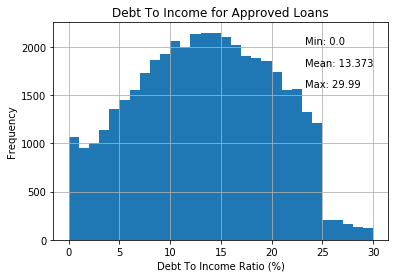

In [3]:
loan_df.dti.hist(bins=30)
plt.xlabel("Debt To Income Ratio (%)")
plt.ylabel("Frequency")
plt.title("Debt To Income for Approved Loans")
plt.annotate("Min: {}".format(round(loan_df.dti.min(), 4)), (0.75, 0.9), xycoords='axes fraction')
plt.annotate("Mean: {}".format(round(loan_df.dti.mean(), 4)), (0.75, 0.8), xycoords='axes fraction')
plt.annotate("Max: {}".format(round(loan_df.dti.max(), 4)), (0.75, 0.7), xycoords='axes fraction')
plt.show()

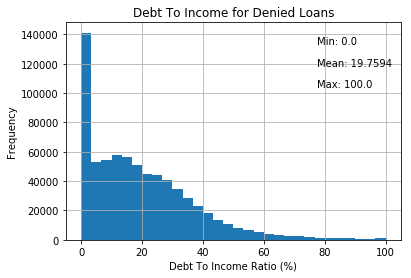

In [4]:
declined_df.dti.hist(bins=30)
plt.xlabel("Debt To Income Ratio (%)")
plt.ylabel("Frequency")
plt.title("Debt To Income for Denied Loans")
plt.annotate("Min: {}".format(round(declined_df.dti.min(), 4)), (0.75, 0.9), xycoords='axes fraction')
plt.annotate("Mean: {}".format(round(declined_df.dti.mean(), 4)), (0.75, 0.8), xycoords='axes fraction')
plt.annotate("Max: {}".format(round(declined_df.dti.max(), 4)), (0.75, 0.7), xycoords='axes fraction')
plt.show()

In [5]:
scores = []

# Sample from declined 5 times and use Stratified 10-fold
# cross validation to get a batch of 10 accuracy scores for
# each sample. Total of 50 accuracy scores, using 5 samples
# of declined data that are equal in size to loan data.

# This takes a while

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    num_score_batches = 5
    for i in range(num_score_batches):
        sample_declined = declined_df.sample(n=len(loan_df))

        print("Scoring sample {}...".format(i + 1))
        scores.append(score_sample(loan_df, sample_declined))
        print("Finished score batch {}".format(i + 1))

Scoring sample 1...
Finished score batch 1
Scoring sample 2...
Finished score batch 2
Scoring sample 3...
Finished score batch 3
Scoring sample 4...
Finished score batch 4
Scoring sample 5...
Finished score batch 5


In [6]:
scores = np.array(scores)
print("Accuracy Scores:")
print(scores)

Accuracy Scores:
[[0.85358255 0.85284602 0.84661474 0.84360019 0.84288111 0.83065676
  0.83545062 0.8168744  0.81807287 0.80405081]
 [0.85194058 0.85050311 0.84475323 0.84173955 0.84545346 0.82352941
  0.84377621 0.82340961 0.8264047  0.80002396]
 [0.84918543 0.84463345 0.84499281 0.85348029 0.84902948 0.82901989
  0.84459621 0.83189552 0.81775701 0.79475198]
 [0.84784953 0.85084461 0.84760992 0.84495567 0.84375749 0.82770189
  0.84745357 0.82276812 0.81354104 0.79808268]
 [0.85120403 0.85228226 0.84796933 0.8465133  0.84735202 0.8271028
  0.84687275 0.82350827 0.81524083 0.80218069]]


In [7]:
print("Mean Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std() * 2))

Mean Accuracy: 0.8352 (+/- 0.0331)


In [80]:
#clean loan status

loan = loan_df[['funded_amnt','emp_length','annual_inc','loan_status','home_ownership','addr_state','tax_liens','grade','int_rate']]

loan['loan_status_clean'] = loan['loan_status'].map({'Current': 2, 'Fully Paid': 1, 'Charged Off':0, 'Late(31-120 days)':0, 'In Grace Period': 0, 'Late(16-30 days)': 0, 'Default': 0})
loan = loan[loan.loan_status_clean != 2] 
loan["loan_status_clean"] = loan["loan_status_clean"].apply(lambda loan_status_clean: 0 if loan_status_clean == 0 else 1)


C:\Users\Roberto Garza\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Mean =  64209.92023685664


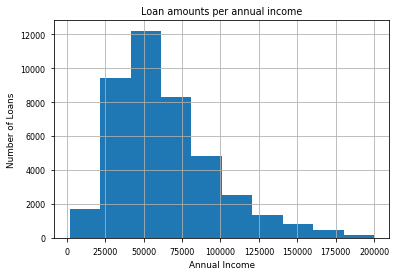

In [81]:
#Loan amounts per annual income
loan = loan[loan['annual_inc']<200000] # to remove small amt of people with high income
loan.annual_inc.hist()
plt.title("Loan amounts per annual income")
plt.xlabel('Annual Income')
plt.ylabel('Number of Loans')
print("Mean = ",loan['annual_inc'].mean())

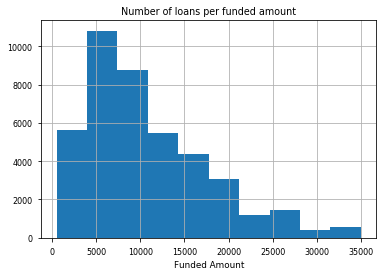

In [82]:
#Approved loans of funded amounts histogram
loan['funded_amnt'].hist()
plt.title("Number of loans per funded amount")
plt.xlabel("Funded Amount")
plt.show()

Text(0,0.5,'Years worked')

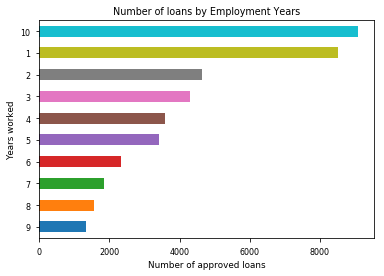

In [83]:
#Number of loans by employment years
loan['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan['emp_length'].value_counts().sort_values().plot(kind='barh')
plt.title('Number of loans by Employment Years')
plt.xlabel('Number of approved loans')
plt.ylabel('Years worked')

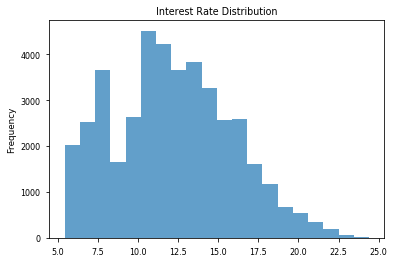

In [89]:
#Interest Rate Distribution
loan['int_rate'].plot(kind='hist',alpha=.7, bins=20, title='Interest Rate Distribution')

In [87]:
clf = linear_model.LogisticRegression()

myVars0 = ['int_rate']
x0 = loan[myVars0]
x0 = x0.values
y0 = loan['loan_status_clean'].values
model0 = clf.fit(x0,y0)
model0.score(x0, y0)
pd.DataFrame(list(zip(myVars0,model0.coef_.T)))

,0,1
0,int_rate,[-0.14042237893585105]


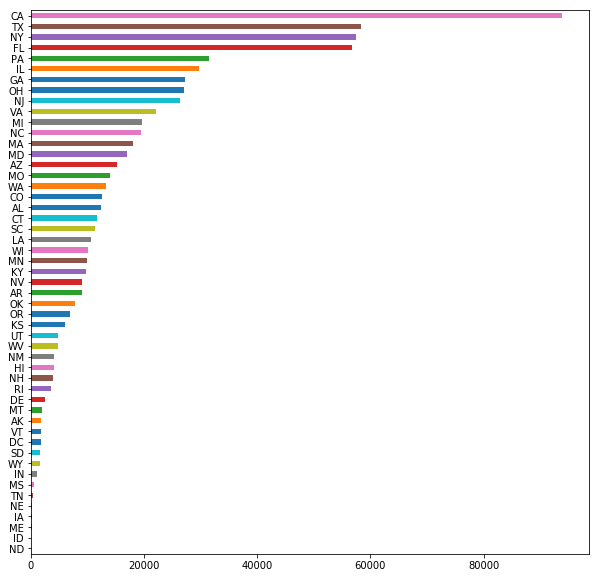

In [20]:
#declined loan data state barh
loanR2 = declined_df
loanR2['addr_state'].value_counts().sort_values().plot(kind='barh',figsize=(10,10))


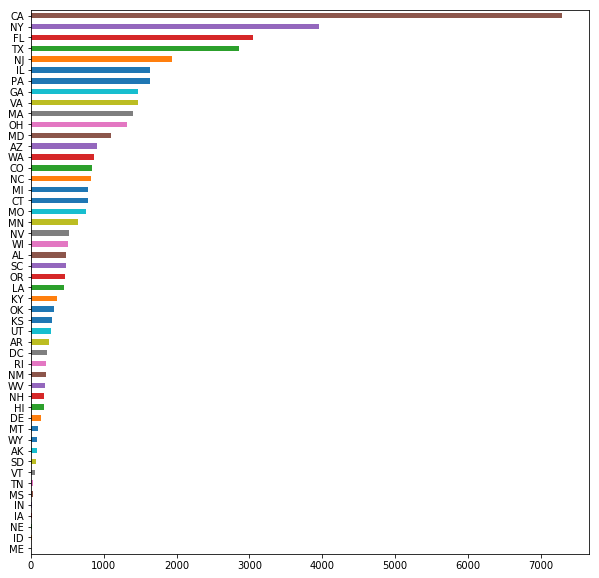

In [19]:
loan['addr_state'].value_counts().sort_values().plot(kind='barh',figsize=(10,10))

In [21]:
#Logistic Regression of Funded Amount and Annual Income
clf = linear_model.LogisticRegression()

myVars = ['funded_amnt', 'annual_inc']
x = loan[myVars]
x = x.values
y = loan['loan_status_clean'].values
model = clf.fit(x,y)
model.score(x, y)
pd.DataFrame(list(zip(myVars,model.coef_.T)))

,0,1
0,funded_amnt,[-1.1249035452500546e-05]
1,annual_inc,[3.0441624845929784e-05]


In [22]:
#low coefficients because the amounts used are dollar amounts which are very high. 
#Example, if the amount funded increased by $1,000, 
#the chance of getting paid back would be -0.01126 or
#1000*-0.00001126

#whereas for annual income, if it increases by $10,000
#the chance of paying back goes up by 0.3044
#or 1000 *0.00030446

In [29]:
#Logistic Regression based on home ownership
loan.home_ownership.unique().tolist()
home_ownership = pd.get_dummies(loan.home_ownership)
#loan = loan.join(home_ownership)

myVars2 = ['RENT', 'MORTGAGE', 'OWN', 'NONE', 'OTHER']
x2 = loan[myVars2]
x2 = x2.values
y2 = loan['loan_status_clean'].values
model2 = clf.fit(x2,y2)
model2.score(x2,y2)
pd.DataFrame(list(zip(myVars2, model2.coef_.T)))


,0,1
0,RENT,[0.2341771557197848]
1,MORTGAGE,[0.3689962538516695]
2,OWN,[0.2586799901358629]
3,NONE,[0.43272681248798905]
4,OTHER,[0.2751973719821517]


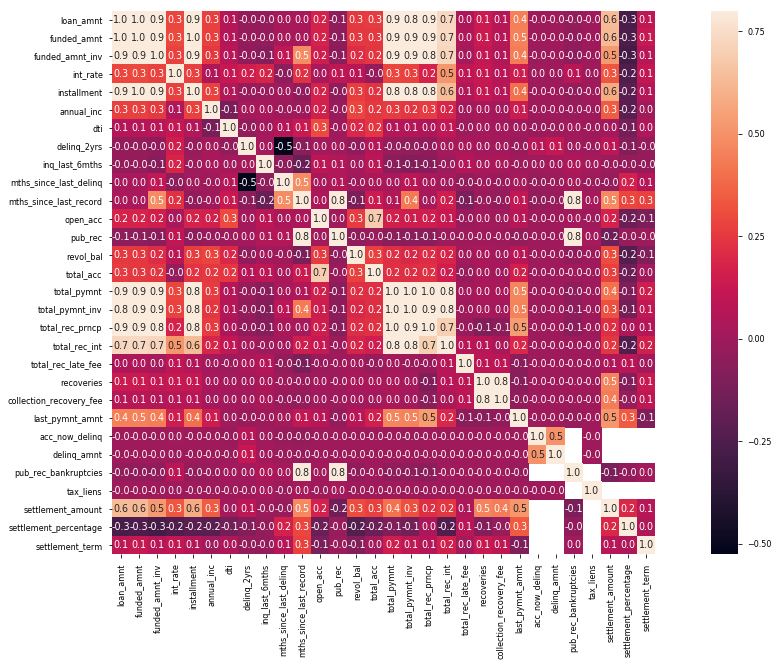

In [25]:
import seaborn as sns


plt.figure(figsize=(20,10))
sns.set_context("paper", font_scale=1)
sns.heatmap(loan_df.corr(), vmax=.8, square=True, annot=True, fmt='.1f')

In [28]:
#Statistical Tests
#Hypothesis is there is no correlation between


In [48]:
#clean employment length
loan['emp_length_clean'] = loan.emp_length.str.replace('+','')
loan['emp_length_clean'] = loan.emp_length_clean.str.replace('<','')
loan['emp_length_clean'] = loan.emp_length_clean.str.replace('years','')
loan['emp_length_clean'] = loan.emp_length_clean.str.replace('year','')
loan['emp_length_clean'] = loan.emp_length_clean.str.replace('n/a','0')
loan['emp_length_clean'].fillna(value=0,inplace=True)

loan.emp_length_clean.unique()

loan['emp_length_clean'] = loan.emp_length_clean.map(float)

Mean =  4.896195430681082


array([10.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7.,  0.])

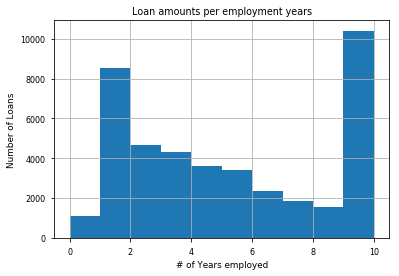

In [49]:
#Employment Length
loan.emp_length_clean.hist()
plt.title("Loan amounts per employment years")
plt.xlabel('# of Years employed')
plt.ylabel('Number of Loans')
print("Mean = ",loan['emp_length_clean'].mean())
loan.emp_length_clean.unique()


In [58]:
emp_dummies = pd.get_dummies(loan.emp_length)
#loan = loan.join(emp_dummies)
myVars3= ['1','1','2','3','4','5','6','7','8','9','10']
x3= loan[myVars3]
y3 = loan['loan_status_clean'].values
model3 = clf.fit(x3,y3)
model3.score(x3, y3)
pd.DataFrame(list(zip(myVars3,model3.coef_.T)))

,0,1
0,1,[0.27729617395738376]
1,1,[0.27729617395738376]
2,2,[0.6160830723612074]
3,3,[0.5471867559042471]
4,4,[0.5543810541325039]
5,5,[0.5083516492773049]
6,6,[0.5263864893401898]
7,7,[0.43444093346703955]
8,8,[0.5280168441248637]
9,9,[0.6334357422387494]


In [71]:
loan['grade_clean'] = loan['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})

grade = loan.grade
mean_grade_clean = loan[loan.grade.notnull()].grade_clean.mean()
loan.grade_clean.fillna(mean_grade_clean, inplace=True)

vars = ['grade_clean']
x4 = loan[vars]
x4 = x4.values
y4 = loan['loan_status_clean'].values

model4 = clf.fit(x4,y4)
model4.score(x4, y4)
pd.DataFrame(list(zip(vars,model.coef_.T)))

,0,1
0,grade_clean,[0.29091261476434344]


Mean =  5.338335770623067


array([6, 5, 7, 3, 2, 4, 1], dtype=int64)

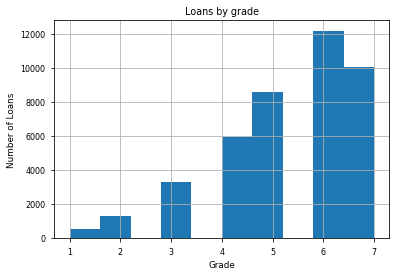

In [75]:
#Employment Length
loan.grade_clean.hist()
plt.title("Loans by grade")
plt.xlabel('Grade')
plt.ylabel('Number of Loans')
print("Mean = ",loan['grade_clean'].mean())
loan.grade_clean.unique()

Text(0,0.5,'Grade')

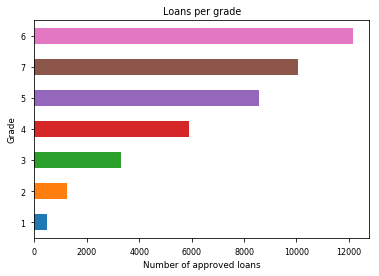

In [77]:
loan['grade_clean'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
loan['grade_clean'].value_counts().sort_values().plot(kind='barh')
plt.title('Loans per grade')
plt.xlabel('Number of approved loans')
plt.ylabel('Grade')